# Context Setting
As someone with little finance knowledge, I wanted to explore what some basic finance terms meant -- using S&P 500 data pulled from Yahoo Finance as a live example. Here, we will display various metrics and calculations, along with the definition.

In [603]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define ticker and timeframe
ticker = "^GSPC"
start_date = (datetime.today() - timedelta(days=365 * 17)).strftime('%Y-%m-%d') # 5 years ago
end_date = datetime.today().strftime('%Y-%m-%d')

# Download and save to CSV
sp500 = yf.download(ticker, start=start_date, end=end_date)
sp500.to_csv("sp500_data.csv")
print("Saved to sp500_data.csv")
print(sp500.head())


/var/folders/t5/x93h4kds34110n67wlm59khw0000gn/T/ipykernel_51607/1023393992.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Saved to sp500_data.csv
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2008-07-29  1263.199951  1263.199951  1236.380005  1236.380005  5414240000
2008-07-30  1284.260010  1284.329956  1264.520020  1264.520020  5631330000
2008-07-31  1267.380005  1284.930054  1265.969971  1281.369995  5346050000
2008-08-01  1260.310059  1270.520020  1254.540039  1269.420044  4684870000
2008-08-04  1249.010010  1260.489990  1247.449951  1253.270020  4562280000


From the above output, we can see that the data pulled requires some formatting before being parsed into a dataframe.

We define the columns as seen below.

In [604]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV
columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv("sp500_data.csv", skiprows=3, names=columns)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Display the first few rows
print(df.head())

                  Close         High          Low         Open      Volume
Date                                                                      
2008-07-29  1263.199951  1263.199951  1236.380005  1236.380005  5414240000
2008-07-30  1284.260010  1284.329956  1264.520020  1264.520020  5631330000
2008-07-31  1267.380005  1284.930054  1265.969971  1281.369995  5346050000
2008-08-01  1260.310059  1270.520020  1254.540039  1269.420044  4684870000
2008-08-04  1249.010010  1260.489990  1247.449951  1253.270020  4562280000


Here we define some additional calculations that are necessary for our different visualisations.

In [605]:
# Calculate daily returns from 'Close'
df['Daily Return'] = df['Close'].pct_change() # pct_change() calculates the percentage change between the current and prior element

# Rolling volatility and mean return
df['30d Volatility'] = df['Daily Return'].rolling(30).std() # Standard deviation of daily returns over a 30-day window
df['30d Mean Return'] = df['Daily Return'].rolling(30).mean() # Mean return over a 30-day window

# Cumulative return
df['Cumulative Return'] = (1 + df['Daily Return']).cumprod() # Cumulative product of daily returns

# Drawdown
df['Cumulative Max'] = df['Cumulative Return'].cummax()
df['Drawdown'] = df['Cumulative Return'] / df['Cumulative Max'] - 1

print(df.head())

                  Close         High          Low         Open      Volume  \
Date                                                                         
2008-07-29  1263.199951  1263.199951  1236.380005  1236.380005  5414240000   
2008-07-30  1284.260010  1284.329956  1264.520020  1264.520020  5631330000   
2008-07-31  1267.380005  1284.930054  1265.969971  1281.369995  5346050000   
2008-08-01  1260.310059  1270.520020  1254.540039  1269.420044  4684870000   
2008-08-04  1249.010010  1260.489990  1247.449951  1253.270020  4562280000   

            Daily Return  30d Volatility  30d Mean Return  Cumulative Return  \
Date                                                                           
2008-07-29           NaN             NaN              NaN                NaN   
2008-07-30      0.016672             NaN              NaN           1.016672   
2008-07-31     -0.013144             NaN              NaN           1.003309   
2008-08-01     -0.005578             NaN             

We provide a list of events with its associated regime (bull / bear) to help us look at patterns within the data.

It is useful to understand what exactly are market regimes. By definition, a bear market is a decline of 20% or more from a recent peak, lasting for a period of time. A bear market ends when an index rises 20% or more from the bottom.

- Green: Bull markets
- Red: Bear markets

/var/folders/t5/x93h4kds34110n67wlm59khw0000gn/T/ipykernel_51607/3846107072.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


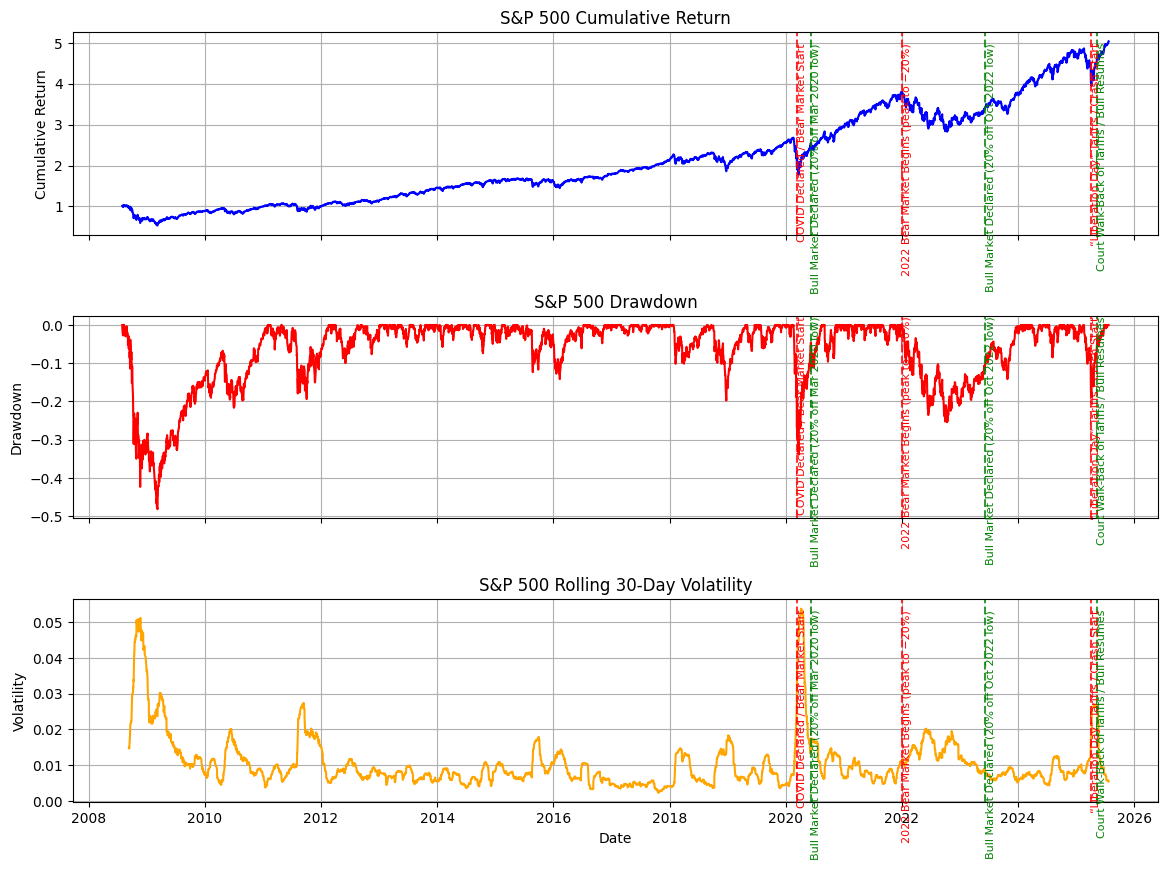

In [606]:
events = {
    # COVID‑19 Bear market begins
    '2020-03-11': 'COVID Declared / Bear Market Start',
    # Recovery to new bull market
    '2020-06-08': 'Bull Market Declared (20% off Mar 2020 low)',
    # 2022 inflation‑rate driven bear market
    '2022-01-03': '2022 Bear Market Begins (peak to −20%)',
    # Bull market resumes post‑2022 low
    '2023-06-08': 'Bull Market Declared (20% off Oct 2022 low)',
    # 2025 “Liberation Day” Tariffs shock → bear market
    '2025-04-02': '“Liberation Day” Tariffs / Crash Start',
    # Tariff rollback and bull rebound
    '2025-05-13': 'Court Walk-Back of Tariffs / Bull Resumes',
}

# Convert keys to datetime
event_dates = [pd.to_datetime(date) for date in events.keys()]
annotations = list(events.values())

# Plot all three metrics
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True, gridspec_kw={'hspace': 0.4})

# 1. Cumulative Return
axs[0].plot(df.index, df["Cumulative Return"], color='blue')
axs[0].set_title("S&P 500 Cumulative Return")
axs[0].set_ylabel("Cumulative Return")
axs[0].grid(True)

# 2. Drawdown
axs[1].plot(df.index, df["Drawdown"], color='red')
axs[1].set_title("S&P 500 Drawdown")
axs[1].set_ylabel("Drawdown")
axs[1].grid(True)

# 3. Rolling Volatility
axs[2].plot(df.index, df["30d Volatility"], color='orange')
axs[2].set_title("S&P 500 Rolling 30-Day Volatility")
axs[2].set_ylabel("Volatility")
axs[2].set_xlabel("Date")
axs[2].grid(True)

# Define colors based on bull/bear/neutral
def get_event_color(label):
    label_lower = label.lower()
    if "bull" in label_lower:
        return 'green'
    elif "bear" in label_lower or "crash" in label_lower:
        return 'red'
    else:
        return 'gray'

# Add vertical lines with color coding
for ax in axs:
    for date, label in zip(event_dates, annotations):
        if df.index.min() <= date <= df.index.max():
            color = get_event_color(label)
            ax.axvline(x=date, color=color, linestyle='--', alpha=0.8)
            ax.text(date, ax.get_ylim()[1]*0.95, label, rotation=90, 
                    verticalalignment='top', fontsize=8, color=color)

plt.tight_layout()
plt.show()


Starting with 3 basic graphs above, we can kind of form an intuition into what's happening. The cumulative returns graph shows us how the stock's price changes over time, while the drawdown shows how much it has dropped since then. The rolling 30-day volatility shows the standard deviation of daily returns over the past 30 days, and is an indicator of risk.

From the graphs, we can kind of see that it works as expected. "Negative" events or the anticipation of them drives prices down, reflected in the returns and drawdown graphs, and volatility rises in accordance with that. "Positive" events do the reverse, driving prices up and reducing volatility.

My first thought on seeing these graphs is whether there's an opposite of the drawdown graph. I initially coded a drawup graph which was just the opposite, but since prices rise naturally, it doesn't particularly make sense to do a drawup graph per se. Doing more research, I learnt about run-up graphs, and attempted to add one to the graphs. Here, I added a run-up graph and added log returns, which are more commonly used for mathematical convenience to my understanding.

In [607]:
df['Bear Start'] = (df['Drawdown'] <= -0.20) & (df['Drawdown'].shift(1) > -0.20)

# Step 2.1: Mark trough price on bear start day
df['Bear Trough Price'] = np.where(df['Bear Start'], df['Close'], np.nan)

# Step 2.2: Forward-fill the latest bear trough value
df['Bear Trough Price'] = df['Bear Trough Price'].ffill()
df['Run-Up From Trough'] = (df['Close'] - df['Bear Trough Price']) / df['Bear Trough Price']

# Optional: flag only first time each run-up crosses 20%
df['Bull Confirm'] = (df['Run-Up From Trough'] >= 0.20) & (df['Run-Up From Trough'].shift(1) < 0.20)

# Logarithmic returns
df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1)) # Logarithmic return
df['Rolling Log Return'] = df['Log Return'].rolling(window=185).sum() # 30-day rolling mean of log returns

print(df.head())

                  Close         High          Low         Open      Volume  \
Date                                                                         
2008-07-29  1263.199951  1263.199951  1236.380005  1236.380005  5414240000   
2008-07-30  1284.260010  1284.329956  1264.520020  1264.520020  5631330000   
2008-07-31  1267.380005  1284.930054  1265.969971  1281.369995  5346050000   
2008-08-01  1260.310059  1270.520020  1254.540039  1269.420044  4684870000   
2008-08-04  1249.010010  1260.489990  1247.449951  1253.270020  4562280000   

            Daily Return  30d Volatility  30d Mean Return  Cumulative Return  \
Date                                                                           
2008-07-29           NaN             NaN              NaN                NaN   
2008-07-30      0.016672             NaN              NaN           1.016672   
2008-07-31     -0.013144             NaN              NaN           1.003309   
2008-08-01     -0.005578             NaN             

/var/folders/t5/x93h4kds34110n67wlm59khw0000gn/T/ipykernel_51607/159352127.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


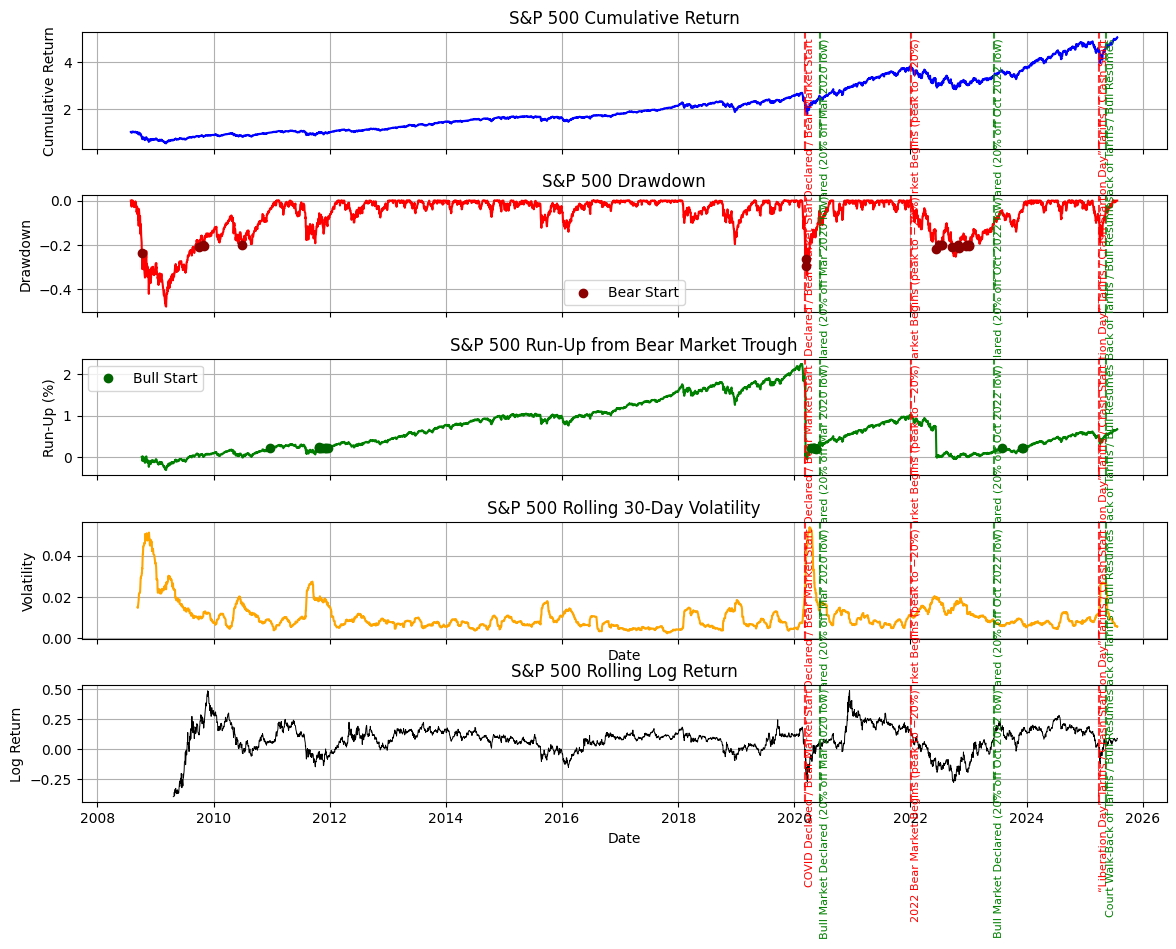

In [608]:
events = {
    # COVID‑19 Bear market begins
    '2020-03-11': 'COVID Declared / Bear Market Start',
    # Recovery to new bull market
    '2020-06-08': 'Bull Market Declared (20% off Mar 2020 low)',
    # 2022 inflation‑rate driven bear market
    '2022-01-03': '2022 Bear Market Begins (peak to −20%)',
    # Bull market resumes post‑2022 low
    '2023-06-08': 'Bull Market Declared (20% off Oct 2022 low)',
    # 2025 “Liberation Day” Tariffs shock → bear market
    '2025-04-02': '“Liberation Day” Tariffs / Crash Start',
    # Tariff rollback and bull rebound
    '2025-05-13': 'Court Walk-Back of Tariffs / Bull Resumes',
}

# Convert keys to datetime
event_dates = [pd.to_datetime(date) for date in events.keys()]
annotations = list(events.values())

# Plot all three metrics
fig, axs = plt.subplots(5, 1, figsize=(14, 10), sharex=True, gridspec_kw={'hspace': 0.4})

# 1. Cumulative Return
axs[0].plot(df.index, df["Cumulative Return"], color='blue')
axs[0].set_title("S&P 500 Cumulative Return")
axs[0].set_ylabel("Cumulative Return")
axs[0].grid(True)

# 2. Drawdown
axs[1].plot(df.index, df["Drawdown"], color='red')
axs[1].set_title("S&P 500 Drawdown")
axs[1].set_ylabel("Drawdown")
axs[1].grid(True)

if 'Bear Start' in df.columns:
    axs[1].scatter(
        df[df['Bear Start']].index,
        df[df['Bear Start']]["Drawdown"],
        color='darkred',
        label='Bear Start',
        marker='o',
        zorder=5
    )
    axs[1].legend()

# 3. Run-Up from Last Bear Market Trough
axs[2].plot(df.index, df["Run-Up From Trough"], color='green')
axs[2].set_title("S&P 500 Run-Up from Bear Market Trough")
axs[2].set_ylabel("Run-Up (%)")
axs[2].grid(True)

# Optional: mark bull confirmation points
if 'Bull Confirm' in df.columns:
    axs[2].scatter(
        df[df['Bull Confirm']].index,
        df[df['Bull Confirm']]["Run-Up From Trough"],
        color='darkgreen',
        label='Bull Start',
        marker='o',
        zorder=5
    )
    axs[2].legend()

# 4. Rolling Volatility
axs[3].plot(df.index, df["30d Volatility"], color='orange')
axs[3].set_title("S&P 500 Rolling 30-Day Volatility")
axs[3].set_ylabel("Volatility")
axs[3].set_xlabel("Date")
axs[3].grid(True)

# 5. Log Returns
axs[4].plot(df.index, df["Rolling Log Return"], color='black', linewidth=0.7)
axs[4].set_title("S&P 500 Rolling Log Return")
axs[4].set_ylabel("Log Return")
axs[4].set_xlabel("Date")
axs[4].grid(True)

# Define colors based on bull/bear/neutral
def get_event_color(label):
    label_lower = label.lower()
    if "bull" in label_lower:
        return 'green'
    elif "bear" in label_lower or "crash" in label_lower:
        return 'red'
    else:
        return 'gray'

# Add vertical lines with color coding
for ax in axs:
    for date, label in zip(event_dates, annotations):
        if df.index.min() <= date <= df.index.max():
            color = get_event_color(label)
            ax.axvline(x=date, color=color, linestyle='--', alpha=0.8)
            ax.text(date, ax.get_ylim()[1]*0.95, label, rotation=90, 
                    verticalalignment='top', fontsize=8, color=color)



plt.tight_layout()
plt.show()


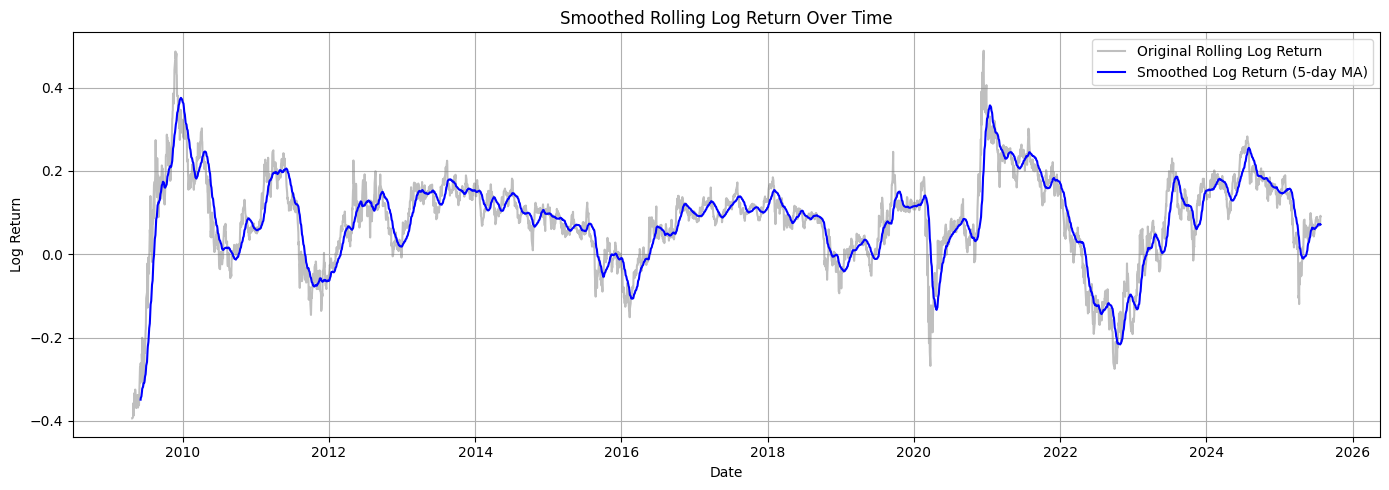

In [609]:
df['Smoothed Log Return'] = df['Rolling Log Return'].rolling(window=5).mean()
df['Log Return Slope'] = df['Smoothed Log Return'].rolling(30).apply(
    lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=True
)

# Step 1: Smooth the rolling log return (e.g., 5-day moving average)
df['Smoothed Log Return'] = df['Rolling Log Return'].rolling(window=30).mean()

# Step 2: Plot the original and smoothed series
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Rolling Log Return'], label='Original Rolling Log Return', color='gray', alpha=0.5)
plt.plot(df.index, df['Smoothed Log Return'], label='Smoothed Log Return (5-day MA)', color='blue')

# Step 3: Customize plot
plt.title("Smoothed Rolling Log Return Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


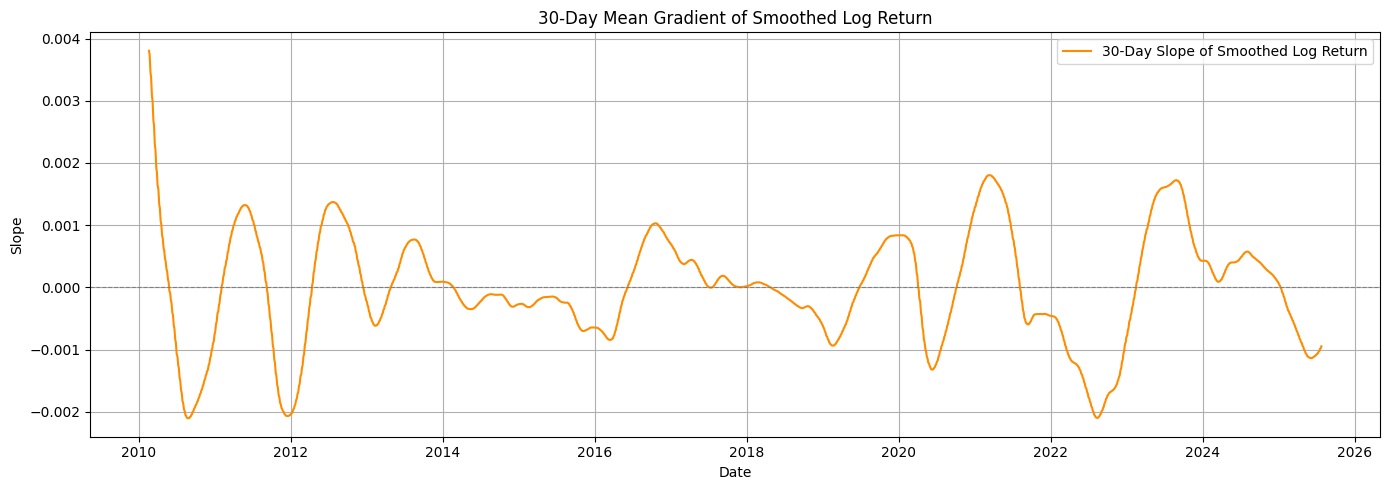

In [610]:
# Compute the 30-day rolling slope (gradient)
def compute_slope(x):
    y = x.values
    x_vals = np.arange(len(y))
    slope, _ = np.polyfit(x_vals, y, 1)
    return slope

df['Log Return Slope'] = df['Smoothed Log Return'].rolling(window=180).apply(compute_slope, raw=False)

plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Log Return Slope'], color='darkorange', label='30-Day Slope of Smoothed Log Return')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("30-Day Mean Gradient of Smoothed Log Return")
plt.xlabel("Date")
plt.ylabel("Slope")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


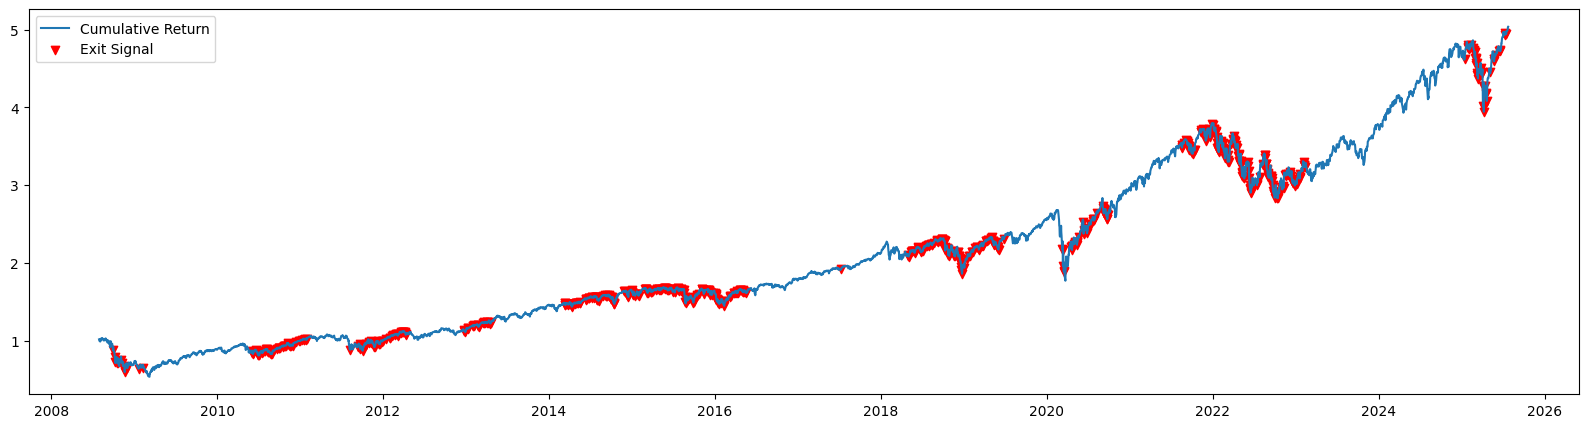

In [611]:
df['Exit Signal'] = (
    (
        df['Log Return Slope'].rolling(window=3).apply(lambda x: all(x < 0), raw=True) == 1
    ) & (df['Log Return'].rolling(window=3).mean() < 0)
) | (df['Log Return'] < -0.05)  # sudden crash OR prolonged slope downtrend


plt.figure(figsize=(20, 5))
plt.plot(df.index, df['Cumulative Return'], label='Cumulative Return')
plt.scatter(df[df['Exit Signal']].index, df[df['Exit Signal']]['Cumulative Return'],
            color='red', label='Exit Signal', marker='v')
plt.legend()

In [616]:
print(df.head())

                  Close         High          Low         Open      Volume  \
Date                                                                         
2008-07-29  1263.199951  1263.199951  1236.380005  1236.380005  5414240000   
2008-07-30  1284.260010  1284.329956  1264.520020  1264.520020  5631330000   
2008-07-31  1267.380005  1284.930054  1265.969971  1281.369995  5346050000   
2008-08-01  1260.310059  1270.520020  1254.540039  1269.420044  4684870000   
2008-08-04  1249.010010  1260.489990  1247.449951  1253.270020  4562280000   

            Daily Return  30d Volatility  30d Mean Return  Cumulative Return  \
Date                                                                           
2008-07-29           NaN             NaN              NaN                NaN   
2008-07-30      0.016672             NaN              NaN           1.016672   
2008-07-31     -0.013144             NaN              NaN           1.003309   
2008-08-01     -0.005578             NaN             

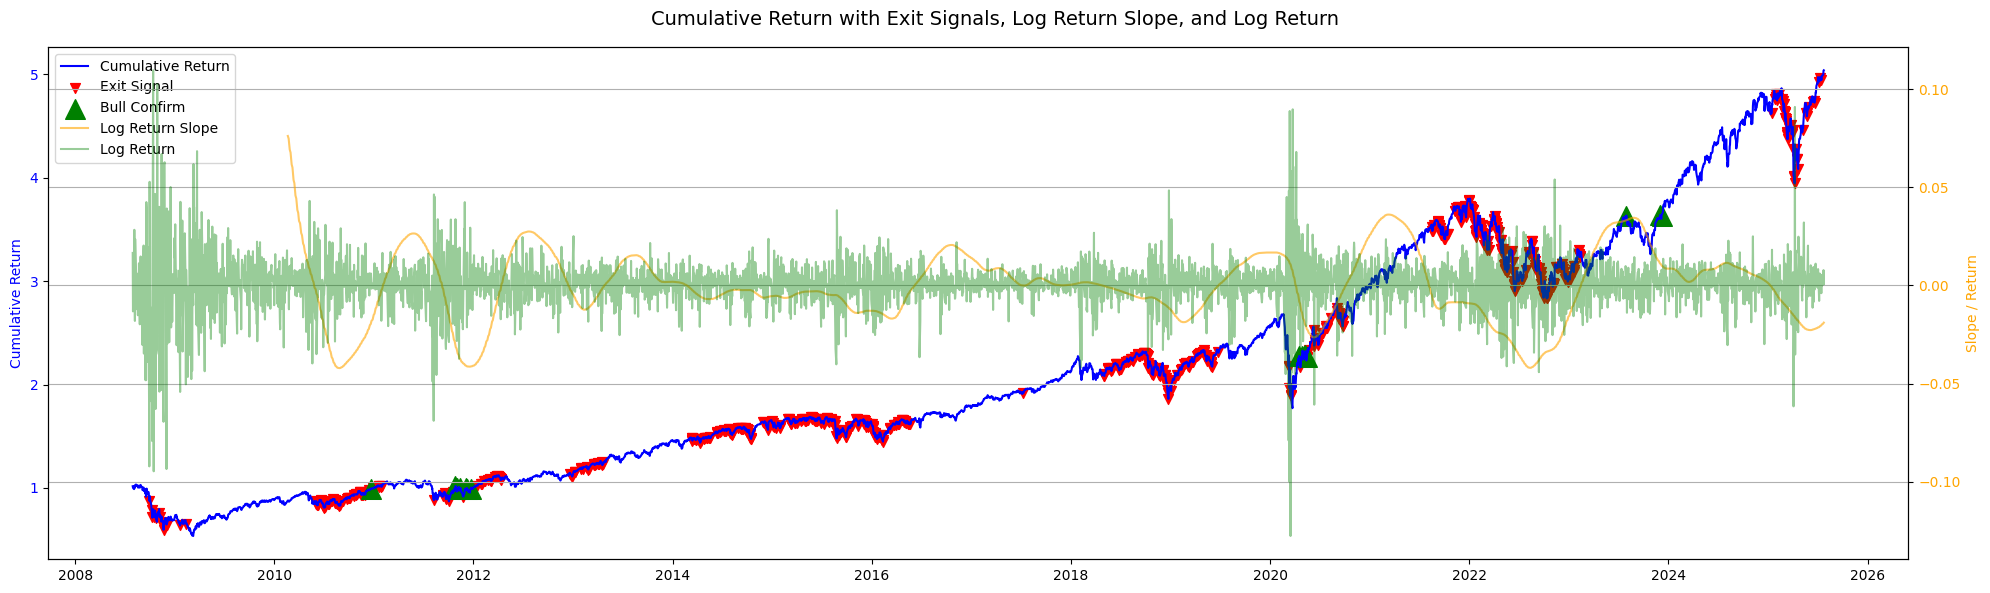

In [619]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(20, 6))

# Primary axis: Cumulative Return and Exit Signals
ax1.plot(df.index, df['Cumulative Return'], label='Cumulative Return', color='blue')
ax1.scatter(df[df['Exit Signal']].index, df[df['Exit Signal']]['Cumulative Return'],
            color='red', label='Exit Signal', marker='v', s=50)
# New: Bull Confirm signals (e.g., upward triangle)
ax1.scatter(df[df['Bull Confirm']].index, df[df['Bull Confirm']]['Cumulative Return'],
            color='green', label='Bull Confirm', marker='^', s=200)
ax1.set_ylabel("Cumulative Return", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary axis 1: Log Return Slope
ax2 = ax1.twinx()
ax2.plot(df.index, df['Log Return Slope'] * 20, label='Log Return Slope', color='orange', alpha=0.6)
ax2.set_ylabel("Slope / Return", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Optional: Third axis for log returns (overlayed)
# Use the same y-axis as ax2 if scale is similar
ax2.plot(df.index, df['Log Return'], label='Log Return', color='green', alpha=0.4)

# Titles and legends
fig.suptitle("Cumulative Return with Exit Signals, Log Return Slope, and Log Return", fontsize=14)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()


Seeing the run-up graph, we kind of have a better idea of different market regimes in relation to the S&P 500.

When learning about finance, one of the first concepts I was introduced to was the Sharpe Ratio, which to my understanding is the returns over the volatility or risk, where:

$$sharpe\ ratio = \frac{R_p-R_f}{\sigma_p},\ R_p=portfolio\ return, R_f=risk\ free\ rate, \sigma_p=standard\ deviation\ of\ returns$$

Let us define some of the important concepts here, which are:
- Portfolio return
- Risk free rate

**Portfolio return**: the total return earned from collection of assets over a given period

**Risk free rate**: the theoretical return of an investment with zero risk of financial loss (baseline to evaluate against)

Common proxies of the risk free rate are the 3-Month T-Bill Rate (5.2%), Fed Funds Target Rate (5.25%), 10-Year Treasury Yield (4.2%) (2025 approximate values).

In [613]:
# Inputs
returns = df['Daily Return'].dropna()
risk_free_rate_annual = 0.02  # 2% annual
T = 252

# Convert to daily
rf_daily = risk_free_rate_annual / T

# Sharpe Ratio
excess_return = returns - rf_daily
sharpe_ratio_annual = (excess_return.mean() / returns.std()) * np.sqrt(T)
print(f"Sharpe Ratio (annualized): {sharpe_ratio_annual:.4f}")


Sharpe Ratio (annualized): 0.4746


Let's try to backtest a strategy, with predefined entries / exit, along with certain limitations. First, we specify our start:
- We start with $10,000
- We start on 1st January, 2010
- We test our strategy up until the current date
- We compare our strategy to the naive portfolio value from having invested $10,000 on the start date

In [614]:
initial_investment = 10000  # Starting with $10,000
start_date = pd.to_datetime("2010-01-01")  # Start date for backtest
end_date = pd.to_datetime("today")  # Current date
df['Naive Portfolio Value'] = initial_investment * df['Cumulative Return'] # Naive portfolio value based on cumulative returns

We now specify entry and exit conditions, using an all-in approach (will get into other approaches later):

In [615]:
# Define entry and exit conditions

# Entry 1: Buy when Run-Up from Trough crosses 20% (Bull Confirm)
df['Entry Signal'] = df['Bull Confirm'].astype(int)  # 1 for entry, 0 otherwise

# Entry 2: Daily Log Return Spike (When rolling log return exceeds a threshold, e.g., 0.02)
df['Log Return Spike'] = (df['Rolling Log Return'] > 0.02).astype(int)  # 1 for spike, 0 otherwise

# Exit: Sell when Rolling Log Return Trends down and Cumulative Return is stagnant
